Notebook to try implementations/functions of the dreambooth inpainting algorithm.

In [ ]:
import yaml
import itertools
import math
import os
import logging
from pathlib import Path
import wandb

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, upload_folder
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.13.0.dev0")

logger = get_logger(__name__)

# Restrict PyTorch to use only GPU X
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# Set the device to 0 (because it's now the only visible device)
torch.cuda.set_device(0)

def mse_lesion_loss(image, target, mask):
    """Compute the MSE loss between the image and target, only considering the lesion area."""
    return F.mse_loss(image * mask, target * mask)

# Inplementation of validation logging with multiple images from the validation dataset
def log_validation_dataset(text_encoder, tokenizer, unet, vae, args, accelerator, weight_dtype, global_step, val_dataset):
    """Validates the model using multiple input images from the validation dataset and logs the results."""
    logger.info(f"Running validation... \n Generating {args.num_validation_images} images per input.")


    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=accelerator.unwrap_model(unet),
        vae=vae,
        torch_dtype=weight_dtype,
        safety_checker=None,
    )
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    generator = None if args.seed is None else torch.Generator(device=accelerator.device).manual_seed(args.seed)

    total_mse_losses, all_logs = [], []


    log_pbar = tqdm(total=len(val_dataset), desc="Validation", position=0, leave=True)
    for j in range(len(val_dataset)):

        input_image = val_dataset[j]["instance_images"].to(accelerator.device)
        mask = val_dataset[j]["lesion_masks"].to(accelerator.device)

        images, loss = [], []
        for _ in range(args.num_validation_images):
            with torch.autocast("cuda"):
                image = pipeline(args.validation_prompt, image=input_image, mask_image=mask, num_inference_steps=25, generator=generator).images[0]
                images.append(image)

                # if the image size is not the same as the input image, resize it
                if image.size != input_image.size:
                    image = image.resize(input_image.size)
            
            # Convert images to tensors for loss calculation
            input_tensor = transforms.ToTensor()(input_image).unsqueeze(0).to(accelerator.device)
            image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(accelerator.device)

            # Compute MSE losses
            mse_loss = mse_lesion_loss(image_tensor, input_tensor, mask).item()
            loss.append(mse_loss)

        avg_mse_loss = sum(loss) / len(loss)
        total_mse_losses.append(avg_mse_loss)

        if j < args.num_validation_images_to_log:
            logs = {
                f"Validation {j}": [
                    wandb.Image(input_image, caption="Input"),
                    wandb.Image(mask, caption="Mask")
                ] + [wandb.Image(img, caption=f"Generated {i}") for i, img in enumerate(images)],  # Flatten the list
                f"MSE Loss {j}": avg_mse_loss,
            }

        all_logs.append(logs)

        log_pbar.update(1)
        log_pbar.set_postfix({"Validation loss": avg_mse_loss})

    log_pbar.close()
    
    final_mse_loss = sum(total_mse_losses) / len(total_mse_losses)

    for tracker in accelerator.trackers:
        if tracker.name == "wandb":
            for logs in all_logs:
                tracker.log(logs, step=global_step)
            tracker.log({"Validation loss": final_mse_loss}, step = global_step)
        else:
            raise ValueError(f"Tracker '{accelerator.tracker.name}' is not supported for validation logging.")

    del pipeline
    torch.cuda.empty_cache()


def log_validation(text_encoder, tokenizer, unet, vae, args, accelerator, weight_dtype, global_step):
    logger.info(
        f"Running validation... Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )
    image_transforms_resize_and_crop = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution),
        ]
    )

    # take the first image in the args.val_input_image_path and the first mask in the args.val_mask_image_path
    val_input_image_path = list(Path(args.val_input_image_path).glob("*.png"))[0]
    val_mask_image_path = list(Path(args.val_mask_image_path).glob("*.png"))[0]

    # load input image
    input_image = image_transforms_resize_and_crop(Image.open(val_input_image_path).convert("RGB"))
    # create the masked versions (black and grey)
    mask = image_transforms_resize_and_crop(Image.open(val_mask_image_path).convert("RGB"))
    _, masked_image_grey = prepare_mask_and_masked_image(input_image, mask, black_mask=False)
    _, masked_image_black = prepare_mask_and_masked_image(input_image, mask, black_mask=True)
    masked_image_grey = Image.fromarray(((masked_image_grey[0].numpy() + 1.0) * 127.5).astype(np.uint8)).convert("RGB")
    masked_image_black = Image.fromarray(((masked_image_black[0].numpy() + 1.0) * 127.5).astype(np.uint8)).convert("RGB")
    
    # load mask image
    mask_image = image_transforms_resize_and_crop(Image.open(val_mask_image_path).convert("RGB"))

    
    # create pipeline (note: unet and vae are loaded again in float32)
    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=accelerator.unwrap_model(unet),
        vae=vae,
        torch_dtype=weight_dtype,
        safety_checker=None,
    )
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    # run inference
    generator = None if args.seed is None else torch.Generator(device=accelerator.device).manual_seed(args.seed)
    images, images_grey, images_black = [], [], []
    mse_losses, mse_losses_grey, mse_losses_black = [], [], []
    for _ in range(args.num_validation_images):
        with torch.autocast("cuda"):
            image = pipeline(args.validation_prompt, image=input_image, mask_image=mask_image, num_inference_steps=25, generator=generator).images[0]
            image_grey = pipeline(args.validation_prompt, image=masked_image_grey, mask_image=mask_image, num_inference_steps=25, generator=generator).images[0]
            image_black = pipeline(args.validation_prompt, image=masked_image_black, mask_image=mask_image, num_inference_steps=25, generator=generator).images[0]

            # if the image size is not the same as the input image, resize it
            if image.size != input_image.size:
                image = image.resize(input_image.size)
            if image_grey.size != input_image.size:
                image_grey = image_grey.resize(input_image.size)
            if image_black.size != input_image.size:
                image_black = image_black.resize(input_image.size)

        images.append(image)
        images_grey.append(image_grey)
        images_black.append(image_black)

        # Convert images to tensors for loss calculation
        input_tensor = transforms.ToTensor()(input_image).unsqueeze(0).to(accelerator.device)
        image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(accelerator.device)
        image_grey_tensor = transforms.ToTensor()(image_grey).unsqueeze(0).to(accelerator.device)
        image_black_tensor = transforms.ToTensor()(image_black).unsqueeze(0).to(accelerator.device)

        # Compute MSE losses
        mse_loss = F.mse_loss(image_tensor, input_tensor).item()
        mse_loss_grey = F.mse_loss(image_grey_tensor, input_tensor).item()
        mse_loss_black = F.mse_loss(image_black_tensor, input_tensor).item()

        mse_losses.append(mse_loss)
        mse_losses_grey.append(mse_loss_grey)
        mse_losses_black.append(mse_loss_black)

    # Compute average losses
    avg_mse_loss = sum(mse_losses) / len(mse_losses)
    avg_mse_loss_grey = sum(mse_losses_grey) / len(mse_losses_grey)
    avg_mse_loss_black = sum(mse_losses_black) / len(mse_losses_black)        

    for tracker in accelerator.trackers:
        if tracker.name == "wandb":
            tracker.log(
                {
                    "Inputs": [wandb.Image(input_image, caption="Input Image"),
                               wandb.Image(mask_image, caption="Mask Image"),
                               wandb.Image(masked_image_grey, caption="Input Image (Grey)"),
                               wandb.Image(masked_image_black, caption="Input Image (Black)")],
                    "Validation": [wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)],
                    "Validation Grey": [wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images_grey)],
                    "Validation Black": [wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images_black)],
                    "Validation MSE Loss": avg_mse_loss,
                    "Validation MSE Loss Grey": avg_mse_loss_grey,
                    "Validation MSE Loss Black": avg_mse_loss_black,
                },
                step=global_step,
            )
        else:
            ValueError(f"Tracker '{tracker.name}' is not supported for validation logging. Please use 'wandb'.")

    del pipeline
    torch.cuda.empty_cache()


def prepare_mask_and_masked_image(image, mask, black_mask=True, discretize_mask=True):
    image = np.array(image.convert("RGB"))
    # image = image[None].transpose(0, 3, 1, 2)
    image = image.transpose(2, 0, 1)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    # mask = mask[None, None]
    mask = mask[None]
    if discretize_mask:
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
    else:
        mask[mask < 0.0] = 0
        mask[mask >= 1.0] = 1
    mask = torch.from_numpy(mask)

    if black_mask:
        masked_image = image * (mask < 0.5) + (mask >= 0.5) * -1 if discretize_mask else image * (1 - mask)
    else:
        masked_image = image * (mask < 0.5)

    return mask, masked_image


def parse_args():
    config_path = "config_dreambooth_inpaint.yaml"
    
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file '{config_path}' not found.")
    
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    
    # Convert values in config to the correct types (float or int)
    def convert_values(config_dict):
        for key, value in config_dict.items():
            # If the value is a string that can be converted to float or int, convert it
            if isinstance(value, str):
                try:
                    # Try converting to float first (for cases like '5e-6')
                    config_dict[key] = float(value) if '.' in value or 'e' in value else int(value)
                except ValueError:
                    # If conversion fails, leave as string
                    pass
            # Recursively process dicts (in case there are nested structures)
            elif isinstance(value, dict):
                convert_values(value)

    # Convert all values
    convert_values(config)

    class Args:
        def __init__(self, config_dict):
            for key, value in config_dict.items():
                setattr(self, key, value)
    
    args = Args(config)
    
    # Ensure local_rank consistency with environment variable
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if hasattr(args, "local_rank") and env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank
    
    # Validate required arguments
    if not hasattr(args, "instance_data_dir") or args.instance_data_dir is None:
        raise ValueError("You must specify a train data directory.")
        
    return args


class MSInpaintingDataset(Dataset):
    """
    Custom dataset for MS lesion inpainting. Loads paired FLAIR MRI images and corresponding lesion masks.
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        image_paths, # List of image file paths
        mask_paths, # List of corresponding mask file paths
        instance_prompt,
        tokenizer,
        size=512,
        black_mask=True,
        discretize_mask=True,
    ):
        self.size = size
        self.tokenizer = tokenizer
        self.black_mask = black_mask
        self.discretize_mask = discretize_mask

        # self.instance_data_root = Path(instance_data_root)
        # self.mask_data_root = Path(mask_data_root)
        # if not self.instance_data_root.exists() or not self.mask_data_root.exists():
        #     raise ValueError("Instance images root or mask images root doesn't exists.")

        # self.image_paths = sorted(list(self.instance_data_root.iterdir()))
        # self.mask_paths = sorted([self.mask_data_root / img.name for img in self.image_paths]) # Corresponding masks for each image
        
        self.image_paths = image_paths  # List of image file paths
        self.mask_paths = mask_paths  # List of corresponding mask file paths


        # Ensure there are corresponding masks for each image
        assert all(mask.exists() for mask in self.mask_paths), "Some masks are missing for the images!"

        self.num_instance_images = len(self.image_paths)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        self.image_transforms_resize_and_crop = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size),
            ]
        )

        self.image_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image_path = self.image_paths[index % self.num_instance_images]
        instance_image = Image.open(instance_image_path)
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        instance_image = self.image_transforms_resize_and_crop(instance_image)
        instance_prompt = self.instance_prompt
        mask = Image.open(self.mask_paths[index])
        if not mask.mode == "L":
            mask = mask.convert("L")
        mask = self.image_transforms_resize_and_crop(mask)
        # prepare mask and masked image
        mask, masked_image = prepare_mask_and_masked_image(instance_image, mask, black_mask=self.black_mask, discretize_mask=self.discretize_mask)

        example["lesion_masks"] = mask
        example["masked_images"] = masked_image
        example["PIL_images"] = instance_image
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example



In [6]:
args = parse_args()

train_image_paths = sorted(list(Path(args.instance_data_dir).iterdir()))
train_mask_paths = sorted([Path(args.mask_data_dir) / img.name for img in train_image_paths])

# Load the tokenizer
if args.tokenizer_name:
    tokenizer = CLIPTokenizer.from_pretrained(args.tokenizer_name)
elif args.pretrained_model_name_or_path:
    tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_name_or_path, subfolder="tokenizer")

# Training dataset
train_dataset = MSInpaintingDataset(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    instance_prompt=args.instance_prompt,
    tokenizer=tokenizer,
    size=args.resolution,
    black_mask=args.black_mask,
    discretize_mask=args.discretize_mask,
)

print(f"Number of training images: {len(train_dataset)}")

# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=args.validation_split, random_state=args.seed)
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(train_dataset, val_indices)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

Number of training images: 567
Number of training images: 510
Number of validation images: 57


torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
[49406, 988, 534, 1015, 530, 550, 46550, 24938, 24773, 4812, 11261, 269, 49407]


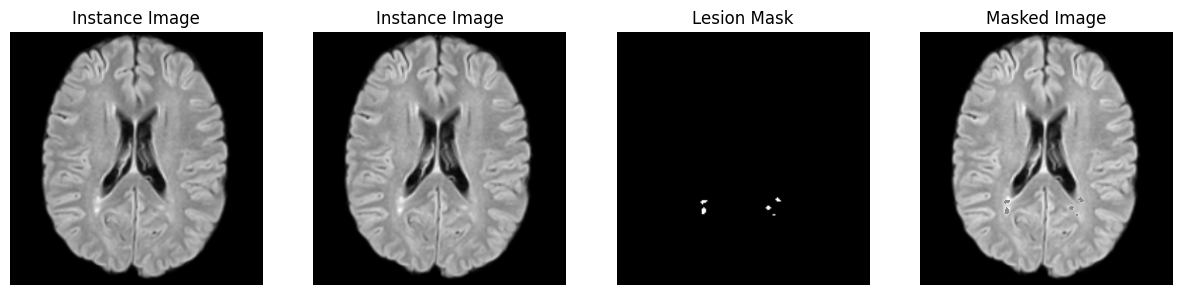

In [8]:
# get one batch of training data and plot it
train_data = train_dataset[2]
print(train_data["instance_images"].shape)
print(train_data["lesion_masks"].shape)
print(train_data["masked_images"].shape)
print(train_data["instance_prompt_ids"])
# print(train_data["PIL_images"])

from matplotlib import pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.imshow(train_data["PIL_images"])
plt.title("Instance Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(train_data["instance_images"][1], cmap="gray")
plt.title("Instance Image")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(train_data["lesion_masks"][0], cmap="gray")
plt.title("Lesion Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(train_data["masked_images"][1], cmap="gray")
plt.title("Masked Image")
plt.axis("off")

plt.show()



In [9]:
train_data["masked_images"].permute(1, 2, 0).cpu().numpy()[0].shape

(256, 3)